<a href="https://colab.research.google.com/github/maiweijie2009/Seattle_airbnb/blob/main/Stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business understanding
Investment firms, hedge funds and even individuals have been using financial models to better understand market behavior and make profitable investments and trades. However, the efficient markets hypothesis and the random walk theory (https://en.wikipedia.org/wiki/Stock_market_prediction) seem to suggest that it is impossible to predict future stock prices by looking at price history. Here I try to build simple machine learning models to see whether it is possible to select stocks in a way better than coin flipping.   

In [18]:
# Install necessary packages and import modules
!pip install pandas-datareader
!pip install yfinance
!pip install ta
# !pip install git+git://github.com/peerchemist/finta.git
# from finta import TA

# !pip install --upgrade ta
import matplotlib.pyplot as plt
from pandas_datareader import data
import pandas as pd
import numpy as np
# from ta import add_all_ta_features
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
import yfinance as yf
from sklearn.model_selection import GridSearchCV
from datetime import datetime
from ta.volatility import *
from ta.momentum import *
from ta.trend import *
from ta.volume import *
from ta.others import *
np.random.seed(0)
# remove the last row if its timestamp is the same as present day
current_date = pd.Timestamp(datetime.now().date())


In [19]:
def fill_na(df):
  """fill missing values in the stock dataframe. First forward then backward filling"""
  df = df.fillna(method='ffill').fillna(method='bfill')
  return df

def generate_TS(df,n_step):
  """generate time series from each columns in df. TS size is n_step"""
  df_size = df.shape[0]
  lst = [] # list to hold all time series
  for row in range(df_size-n_step+1):
    for column in df.columns:
      lst.append(df.iloc[row:row+n_step][column].values.tolist())

  return pd.DataFrame(lst)

# define a function to create buy/cell label
# Buy if in the next "future" days the highest price will be "margin" percent higher than the current open price
def get_label(df,future,margin,remove=True):
  temp = df.copy()
  buy_lst = []
  for row in range(temp.shape[0]):
    end = temp.iloc[row]['Close'] # buy stock at open price
    high = temp.iloc[row+1:row+future+1]['High'].max() # sell at highiest price in "future" days
    buy_lst.append((100*(high-end)/end)>margin)  # buy only if the highest price is significantly higher than the current open price
  
  temp['Buy'] = buy_lst # create label for each day
  # need to remove last rows in training
  if remove:
    temp = temp.iloc[:temp.shape[0]-future] # remove the last few days without sufficient data
  return temp

# define a function to get indicators for a stock 
def get_indicators(df):
  # add RSI indicator
  # indicator_RSI = RSIIndicator(close=df["Close"])
  # df['RSI'] = indicator_RSI.rsi()
  # add Chaikin Money Flow
  CMF = ChaikinMoneyFlowIndicator(high = df['High'],low = df['Low'],volume=df['Volume'],close=df["Close"])
  df['CMF'] = CMF.chaikin_money_flow()   

  # add CCI indicator
  # CCI = CCIIndicator(high = df['High'],low = df['Low'],close=df["Close"])
  # df['CCI'] = CCI.cci()

  # add PPO indicator
  PPO = PercentagePriceOscillator(close=df["Close"])
  df['PPO'] = PPO.ppo()
  df['PPO_signal'] = PPO.ppo_signal() 

  # add PVO indicator
  PVO = PercentageVolumeOscillator(volume=df['Volume'])
  df['PVO'] = PVO.pvo()
  df['PVO_signal'] = PVO.pvo_signal() 


  # add ADX indicator
  ADX = ADXIndicator(high = df['High'],low = df['Low'],close=df["Close"])
  df['ADX'] = ADX.adx()
  df['ADX_neg'] = ADX.adx_neg()
  df['ADX_pos'] = ADX.adx_pos()

  # add ROC indicator
  ROC = ROCIndicator(close=df["Close"])
  df['ROC'] = ROC.roc() 

  # add MFI indicator 
  MFI = MFIIndicator(high = df['High'],low = df['Low'],close=df["Close"],volume=df['Volume'])
  df['MFI'] = MFI.money_flow_index()

  # add TSI indicator
  TSI = TSIIndicator(close=df["Close"])
  df['TSI'] = TSI.tsi()

  # add BollingerBands
  Bollinger = BollingerBands(close=df["Close"])
  df['Bollinger_w'] = Bollinger.bollinger_wband()

  # add UlcerIndex
  UI = UlcerIndex(close=df["Close"])
  df['UI'] = UI.ulcer_index()

  # get the VIX (fear index)
  # df['VIX'] = yf.Ticker('^VIX').history(period=period).Close

  # repalce infinity values with nan
  df.replace([np.inf, -np.inf], np.nan,inplace=True)
  return df


In [29]:
# get tickers
long_term_tickers = ['WMT','FB','AAPL', 'MSFT', 'SPY','GOOGL','AMZN','PFE',
           'AAL','DAL','TSLA','NFLX','UBER','ADBE','BIDU','BABA','GM',
           'CRM','TCEHY','JD','GE','AMD','INTC','PYPL','REGN',
           'BAC','JPM','MELI']
short_term_tickers = ['VVPR','WWR','SURF','PLTR','FUBO','MGA',
           'LRCX','JMIA','RKT','QS','INSM','BLDP','GOGO',
           'ZM','PLUG','TAK','TDY','SE','LI','NIO','GME','GSAT','ZS','DKNG',
           'SPCE','FSR','MVIS','BNGO','DM','UVXY','EXPC','SWTX',
           'TDOC','DE']

tickers = long_term_tickers+short_term_tickers

period = '20y' # period of historic stock data

In [30]:
# get current date
current_date = pd.Timestamp(datetime.now().date())
# if data.index[-1]==current_date:
#   data = data.iloc[:-1]

# Model using technical indicators

In [31]:
df_w_feature_dict = {}
future = 10
margin = 10

# get indictors of each stock
df_w_feature_dict = {ticker:get_indicators(get_label(yf.Ticker(ticker).history(period=period),
                                                     future = future,margin = margin)) for ticker in tickers}

# concat all dataframe to get one dataframe
df_w_feature = pd.concat([df_w_feature_dict[ticker] for ticker in tickers], axis=1, keys=tickers)
# can not drop na over the entire dataframe, as different stocks have different IPO time. Fill na instead
df_w_feature = fill_na(df_w_feature)
 
# remove the last data row if it is the same as the current date
if df_w_feature.index[-1]==current_date:
  df_w_feature = df_w_feature.iloc[:-1]
df_w_feature.tail()


/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/usr/local/lib/python3

WMT                          ...         DE                      
                  Open        High         Low  ...        TSI Bollinger_w        UI
Date                                            ...                                 
2020-12-24  143.539993  144.389999  143.179993  ...  22.830382    9.862428  2.170618
2020-12-28  144.039993  145.300003  143.330002  ...  22.745958   10.160286  1.944963
2020-12-29  145.639999  145.850006  143.589996  ...  21.739280   10.291631  1.775637
2020-12-30  144.880005  145.149994  143.940002  ...  21.359205   10.319726  1.662786
2020-12-31  144.199997  144.270004  142.850006  ...  21.884597   10.685293  1.421357

[5 rows x 1302 columns]

In [32]:
X_all = pd.DataFrame()
Y_all = pd.DataFrame()
# create dataset for model training and tesing
for ticker in tickers:
  df = df_w_feature[ticker]
  df = df.dropna() # drop na. Data before IPO of each stock will be drop
  X_all = pd.concat([X_all,df.iloc[:,8:]])
  Y_all = pd.concat([Y_all,df['Buy']])

Y_all = Y_all.astype('int')

In [33]:
X_all.describe()

,CMF,PPO,PPO_signal,PVO,PVO_signal,ADX,ADX_neg,ADX_pos,ROC,MFI,TSI,Bollinger_w,UI
count,311426.000000,311426.000000,311426.000000,311426.000000,311426.000000,311426.000000,311426.000000,311426.000000,311426.000000,311426.000000,311426.000000,311426.000000,311426.000000
mean,-0.033053,0.058649,0.036522,-17.674621,-16.647961,14.261332,12.656997,13.947428,1.990563,53.780589,4.723830,24.957706,7.391233
std,0.247059,4.413977,4.053063,31.362134,26.933117,14.525759,12.503805,13.741919,18.604186,20.456030,26.333199,25.483549,7.595530
min,-1.000000,-42.550360,-39.675414,-100.000000,-100.000000,0.000000,0.000000,0.000000,-80.000000,0.000000,-73.480957,0.000000,0.000000
25%,-0.169178,-1.608559,-1.395362,-34.643087,-33.324318,0.000000,0.000000,0.000000,-6.218112,40.139656,-13.661526,8.766476,1.915436
50%,-0.013469,0.285668,0.185393,-9.161087,-8.771559,14.605043,13.359833,15.057116,0.509167,54.151643,3.909912,17.026817,4.612981
75%,0.130311,1.874285,1.798297,0.319810,0.623680,24.573334,22.650090,24.834951,5.757578,68.641215,20.416163,32.925346,11.005427
max,1.000000,46.395930,37.913107,107.692308,63.553147,97.450986,78.524708,98.359582,582.080928,100.000000,96.224419,387.473090,73.094929


In [34]:
# train test split
X_train = X_all[X_all.index<'2020']
X_test = X_all[X_all.index>='2020']
Y_train = Y_all[Y_all.index<'2020']
Y_test = Y_all[Y_all.index>='2020']

In [35]:
# train a ensemble classifier with refinement
clf_ensemble_instance = RandomForestClassifier(max_depth=15)
# define paramter space used the grid search of model hyperparameters
param_grid = { 
    'n_estimators': [100],
    'max_features': ['auto'],
    'max_depth' : [12],
    # 'class_weight': ['balanced_subsample'],
    'class_weight':[{0:1.5,1:1}],
    'n_jobs': [-1], # use all cores, much faster 
}
clf_ensemble = GridSearchCV(estimator=clf_ensemble_instance, param_grid=param_grid, cv= 5)
clf_ensemble.fit(X_train,Y_train.values.ravel())

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=15,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_

In [36]:
hyper_paras = clf_ensemble.best_params_ # store hyperparameters of the optimized model
print(classification_report(Y_train, clf_ensemble.predict(X_train))) # prediction report of training set
print(classification_report(Y_test, clf_ensemble.predict(X_test))) # prediction report of testing set
print('Best parameters found:\n', clf_ensemble.best_params_) # print the best model hyperparameters

              precision    recall  f1-score   support

           0       0.87      1.00      0.93    196537
           1       1.00      0.70      0.82     99203

    accuracy                           0.90    295740
   macro avg       0.93      0.85      0.87    295740
weighted avg       0.91      0.90      0.89    295740

              precision    recall  f1-score   support

           0       0.61      0.98      0.75      8915
           1       0.84      0.17      0.28      6771

    accuracy                           0.63     15686
   macro avg       0.72      0.57      0.51     15686
weighted avg       0.71      0.63      0.55     15686

Best parameters found:
 {'class_weight': {0: 1.5, 1: 1}, 'max_depth': 12, 'max_features': 'auto', 'n_estimators': 100, 'n_jobs': -1}


<BarContainer object of 13 artists>

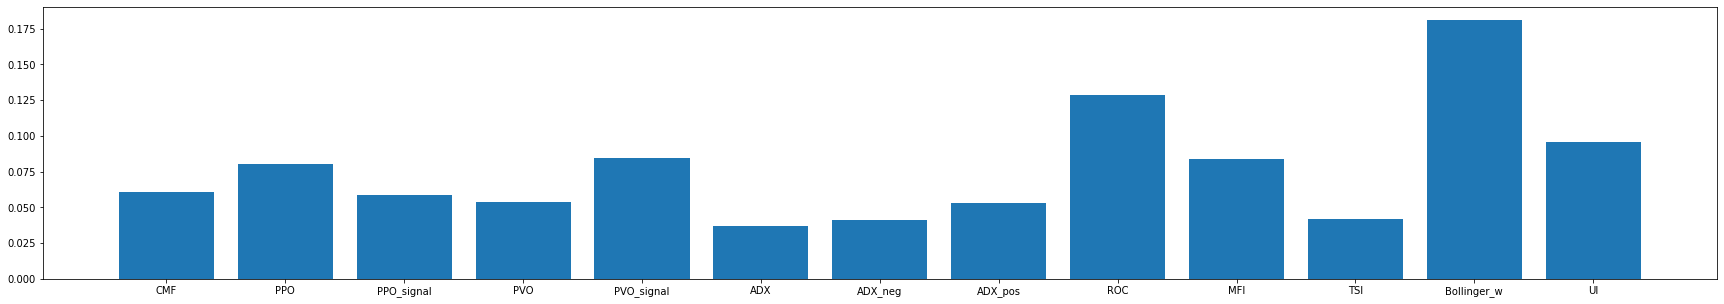

In [37]:
# plot feature importance
importance = clf_ensemble.best_estimator_.feature_importances_
fig = plt.figure(figsize=(30, 5))
plt.bar(X_train.columns,importance)

In [38]:
# train a model using all data with the optimized parameter
clf = RandomForestClassifier(**hyper_paras)
clf.fit(X_all,Y_all.values.ravel())



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.5, 1: 1}, criterion='gini',
                       max_depth=12, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [43]:
# check model accuracy for stocks in the test set
df_w_feature_dict_test = {}

# ticker used to test the model result
test_tickers = ['GE','GS','JNJ','AMAT','PG','MA','MRK','MMM']


# get indictors of each stock
df_w_feature_dict_test = {ticker:get_indicators(get_label(yf.Ticker(ticker).history(period=period),
                                                     future = future,margin = margin)) for ticker in test_tickers}

# concat all dataframe to get one dataframe
df_w_feature_test = pd.concat([df_w_feature_dict_test[ticker] for ticker in test_tickers], axis=1, keys=tickers)
# can not drop na over the entire dataframe, as different stocks have different IPO time. Fill na instead
df_w_feature_test = fill_na(df_w_feature_test)
 
# remove the last data row if it is the same as the current date
if df_w_feature_test.index[-1]==current_date:
  df_w_feature_test = df_w_feature_test.iloc[:-1]

X_test2 = pd.DataFrame()
Y_test2 = pd.DataFrame()
# create dataset for model training and tesing
for ticker in test_tickers:
  df = df_w_feature_dict_test[ticker]
  df = df.dropna() # drop na. Data before IPO of each stock will be drop
  X_test2 = pd.concat([X_test2,df.iloc[:,8:]])
  Y_test2 = pd.concat([Y_test2,df['Buy']])

# train test split
X_test2 = X_test2[X_test2.index>='2020']
Y_test2 = Y_test2[Y_test2.index>='2020']

Y_test2 = Y_test2.astype('int')

print(classification_report(Y_test2, clf.predict(X_test2))) # prediction report of testing set2

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/usr/local/lib/python3

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      1497
           1       0.95      0.07      0.12       274

    accuracy                           0.85      1771
   macro avg       0.90      0.53      0.52      1771
weighted avg       0.87      0.85      0.80      1771



In [44]:
# make prediction of all stocks of interst, with class probability 
predict_list = []
stocks = []
current_date = pd.Timestamp(datetime.now().date())
for ticker in tickers:
  stocks.append(ticker)
  stock = yf.Ticker(ticker)
  df = get_label(stock.history(period=period),future = future,margin = margin,remove=False)
  df = get_indicators(df)

  # before the end of market, the last row show be removed. After end of market, the last row should not be removed
  if df.index[-1]==current_date:
    df = df.iloc[:-1] #remove the last row if its timestamp is the same as present day

  X_interest = df.iloc[-1,8:]
  predict_list.append(clf.predict_proba(X_interest.values.reshape(1, -1))[0].tolist())
  # print('Stock price of {} increase?: {} {}'.format(stock, clf_ensemble.predict(X_interest.values.reshape(1, -1))[0],clf_ensemble.predict_proba(X_interest.values.reshape(1, -1))))# print prediction

predict_df = pd.DataFrame(predict_list,columns=['Sell','Buy'])
predict_df['Stock'] = stocks
predict_df = predict_df[['Stock','Sell','Buy']].sort_values(by='Buy',ascending=False)
predict_df.reset_index(inplace=True,drop=True)

/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/usr/local/lib/python3

In [45]:
X_interest

CMF            0.223817
PPO             4.13059
PPO_signal      3.53135
PVO            0.691066
PVO_signal     0.515718
ADX             47.0482
ADX_neg         16.7555
ADX_pos         37.6117
ROC             11.6487
MFI             73.7313
TSI             42.5542
Bollinger_w     21.4151
UI              1.21229
Name: 2021-01-15 00:00:00, dtype: object

In [46]:
predict_df.head(15)

,Stock,Sell,Buy
0,GSAT,0.297977,0.702023
1,PLUG,0.336610,0.663390
2,BNGO,0.382232,0.617768
3,GME,0.383646,0.616354
4,JMIA,0.461044,0.538956
5,BLDP,0.494078,0.505922
6,MVIS,0.495482,0.504518
7,DM,0.528402,0.471598
8,FUBO,0.540623,0.459377
9,NIO,0.561055,0.438945
